In [1]:
from z3 import *
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as mpatches
import time


In [3]:
def read_instance_text(f):
    """ 
    It reads the instance datas, in the following format: 
    width
    n_circuits
    Wi, Hi for i in range(n_circuits)
    returns a tuple as (width, List of Wi, List of Hi)
    """
    print(f)
    file = open(f)
    width = int(file.readline())
    # print("width ", width)
    n_piece = int(file.readline())
    W, H =[], []
    for i in range(n_piece):
        piece = file.readline()
        split_piece = piece.strip().split(" ")
        W.append((int(split_piece[0])))
        H.append((int(split_piece[1])))
    # print(pieces)
    return width, W, H


def show_shape(s, title, n_circuits):
    """
    create a image with s as image and title as title of the graph
    :param s:
    :param title:
    :param n_circuits:
    :return:
    """
    s = cv2.merge([s])
    img = plt.imshow(s)

    values, counts = np.unique(s, return_counts=True)
    # print(counts)
    colors = [img.cmap(img.norm(value)) for value in values]
    labels = []
    starting = 0
    if n_circuits + 1 == len(counts):
        starting = 1
        labels.append("Background")
    for i in range(starting, len(counts)):
        labels.append(f"Piece {i + 1}")
    patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(counts))]
    plt.title(title)
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(list(range(0, s.shape[1] + 1)))
    yticks = list(range(0, s.shape[0]))
    # yticks.reverse()
    plt.yticks(yticks)
    plt.ylim(top=s.shape[0])
    plt.ylim(bottom=-0.5)
    plt.xlim(left=-0.5)
    plt.xlim(right=s.shape[1])
    plt.gca().invert_yaxis()
    # plt.grid(b=True)
    # plt.savefig(f"{title}")

    plt.show()


def draw_solution(sol_shape, pieces):
    """
    Returns an array with shape = sol_shape, and pieces drawn in the array
    """
    arr = np.zeros(sol_shape)
    count = 1
    # area = 0
    for x_t, y_t, x, y in pieces:
        # if x == 1:
        #     x = 0
        # if y == 1:
        #     y = 0
        # area += x_t * y_t
        # print(x_t, y_t, x, y)
        arr[x:x + x_t, y:y + y_t] = abs(count) * (250 / len(pieces))
        count += 1
        # print(arr)
        # print(area)
    arr = arr / np.max(arr)
    return np.rot90(arr)

def min_height(shapes):
    return int(np.min([shapes[i][1] for i in range(len(shapes))]))

def compute_area_circuits(W,H):
    return sum([W[i]* H[i] for i in range(len(W))])

def dims_sol_unify(W,H, X,Y): 
    return [(W[i], H[i],X[i],Y[i]) for i in range(len(W))]


def flatten(t):
    return [item for sublist in t for item in sublist]


In [4]:
def vlsi_instance(W, H, dims, width, max_height):
  """
    Variable declaration
    W: width of all circuits
    H: height of all circuits
    dims: number of circuits
    width: width of the board/ solution
    max_height: maximum height reachable by stacking all circuits. 
  """
  # decision variable for the height
  all_constraints = []
  height = Int('height')

  # X component of the solution where to place the circuits
  X = [Int(f"X_{i}") for i in range(dims)]
  
  # Y component of the solution where to place the circuits
  Y = [Int(f"Y_{i}") for i in range(dims)]

  # board boundaries constraints
  boundaries_c_width = [And(0 <= X[i], W[i]+ X[i]<= width) for i in range(dims)]
  all_constraints+= boundaries_c_width

  boundaries_c_height = [0 <= Y[i] for i in range(dims)] #+ np.max([Y[i]+H[i]for i in range(dims)], dtype= int)< height
  all_constraints += boundaries_c_height

  x = [[Int(f"x_{i + 1}_{j + 1}") for j in range(dims)] for i in range(dims)]
  x_domain_cons= [[Or(x[i][j]>=0, x[i][j]<=1) for i in range(dims)] for j in range(dims)]
  all_constraints += flatten(x_domain_cons)
  y = [[Int(f"y_{i + 1}_{j + 1}") for j in range(dims)] for i in range(dims)]
  y_domain_cons=  [[Or(y[i][j]>=0, y[i][j]<=1) for i in range(dims)] for j in range(dims)]
  all_constraints += flatten(y_domain_cons)

  

  # height_constraint = [And(height < max_height, height > min_height(dims))]
  height_constraint = [Y[i]+H[i]<=height for i in range(dims)]
  all_constraints += height_constraint
  # no overlapping constraints

  no_overlapping = []    
  for i in range(dims):
    for j in range(dims): # to fix
      if i != j:
        no_overlapping.append(
          If(X[i]< X[j], # i to the left of j
                X[i] + W[i] <= X[j],
          If(Y[i] < Y[j], # i below j
                Y[i] + H[i] <= Y[j] + 1,
          If(X[i]> X[j], # i to the right of j 
                X[i] - W[j]>= X[j] ,
          If(Y[i] > Y[j], # i above j 
                Y[i] - H[j] >= Y[j],
                False))))) 
  # for i in range(dims):
  #   for j in range(dims): # to fix
  #     if i != j:
  #       no_overlapping.append(
  #         If(X[i] < X[j], # i to the left of j
  #               X[i] + W[i] <= X[j] + width * (x[i][j]+ y[i][j]),
  #         If(Y[i] < Y[j], # i below j
  #               Y[i] + H[i] <= Y[j] + 1 - width * (1-x[i][j]+y[i][j]),
  #         If(X[i] > X[j], # i to the right of j 
  #               X[i] - W[j]>= X[j] + max_height * (1+x[i][j]-y[i][j]),
  #         If(Y[i] > Y[j], # i above j 
  #               Y[i] - H[j] >= Y[j] - max_height * (2-x[i][j]-y[i][j]),
  #               False)))))
  all_constraints += no_overlapping


  """
    Solving phase
  """
  solver = Optimize()
  # print(str(all_constraints))
  solver.add(all_constraints)
  # minimizing function
  circuit_area = compute_area_circuits(W,H)
  
  solver.minimize(height)
  if solver.check() == sat:
    m = solver.model()
    return int(m.evaluate(height).as_string()), [int(m.evaluate(X[i]).as_string()) for i in range(dims)],[int(m.evaluate(Y[i]).as_string()) for i in range(dims)]
  else:
    return solver.reason_unknown()



../../instances/ins-2.txt
Solution (width, height): (9, 9), time: 11.3981s


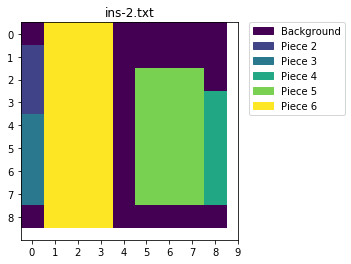

In [5]:
path = "../../instances/"
instances = os.listdir(path)
instances = ["ins-2.txt"]
time_per_instance = []
for i in range(len(instances)): 
#     print(path+instance)
    instance = instances[i]
    width, W, H = read_instance_text(path+instance)
    
#     print(dims)
    max_height = int(np.sum([H[i] for i in range(len(H))]))
#     print(f"Maximum height reachable: {max_height}")

    start_time = time.time_ns()
    returned_value = vlsi_instance(W, H,len(W), width, max_height)
    if returned_value is not tuple:
        height, X,Y = returned_value

        end_time = time.time_ns()
        end_time = (end_time-start_time)/ 10**9
        print(f"Solution (width, height): {width,height}, time: {round(end_time,4)}s")
        # todo fix variables
        time_per_instance.append((instance, end_time))
        solutions = dims_sol_unify(W, H, X, Y)
        # print(solutions)
        arr = draw_solution((width,height), solutions)
        show_shape(arr, instance,len(W))
    else:
        print(returned_value)
        print("Failed to find a solution")

    